<a href="https://colab.research.google.com/github/mralamdari/Machine_Learning_Projects/blob/main/Multi_Classification_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision
import torchsummary
import torch.nn as nn
from PIL import Image, ImageDraw

#1.Data

In [ ]:
def plot_history(history, loss=True):

  num_epochs = len(history['train'])
  print(num_epochs)
  title = 'Loss' if loss else 'Accuracy'
  plt.title(f'Train Validation {title}')
  plt.plot(range(1, num_epochs+1), history['train'], label='Train')
  plt.plot(range(1, num_epochs+1), history['val'], label='Validation')
  plt.xlabel('Trainig Epochs')
  plt.ylabel(title)
  plt.legend()
  plt.grid()
  plt.show()

In [ ]:
"""STL-10 :::: RGB , (96*96)
Airplane: 0
Bird: 1
Car: 2
Cat: 3
Deer: 4
Dog: 5
Horse:6
Monkey: 7
Ship: 8
Truck: 9"""
path2data = '/content/data'
if not os.path.exists(path2data):
  os.mkdir(path2data)

transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_ds = torchvision.datasets.STL10(path2data,
                                      split='train',
                                      download = True,
                                      transform = transformer)
test_ds = torchvision.datasets.STL10(path2data,
                                     split='test',
                                     download=True,
                                     transform = transformer)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /content/data/stl10_binary.tar.gz to /content/data
Files already downloaded and verified


In [ ]:
from sklearn import model_selection
sss = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=43)
indecs = list(range(len(test_ds)))

y_test_ds = [y for _, y in test_ds]

for test_index, val_index in sss.split(indecs, y_test_ds):
  print(f'Test: {test_index}\n Val:{val_index}')
  print(len(test_index), len(val_index))
  val = torch.utils.data.Subset(test_ds, val_index)
  test = torch.utils.data.Subset(test_ds, test_index)
  
y_test = [y for _, y in test]
y_val = [y for _, y in val]

Test: [2720 2206 4570 ... 1454  565 3740]
 Val:[3600 3518   53 ... 6066 3265 3326]
6400 1600


In [ ]:
import collections
yr = [t for _, t in train_ds]
train_counter = collections.Counter(yr)
test_counter = collections.Counter(y_test)
val_counter = collections.Counter(y_val)
print(train_counter)
print(test_counter)
print(val_counter)

Counter({1: 500, 5: 500, 6: 500, 3: 500, 9: 500, 7: 500, 4: 500, 8: 500, 0: 500, 2: 500})
Counter({3: 640, 5: 640, 2: 640, 4: 640, 8: 640, 9: 640, 0: 640, 6: 640, 7: 640, 1: 640})
Counter({2: 160, 1: 160, 0: 160, 8: 160, 9: 160, 7: 160, 5: 160, 4: 160, 3: 160, 6: 160})


In [ ]:
def show_img(ds, count=24, color=True, rand=True, with_y=True):
  
  rnd = np.random.randint(0, len(ds), count) if rand else len(ds) 
  if with_y:
    x_grid = [ds[i][0] for i in rnd]
    y_gird = [ds[i][1] for i in rnd]
  else:
    x_grid = [ds[i] for i in range(rnd)]

  x_grid = torchvision.utils.make_grid(x_grid, nrows=10, padding=1)
  plt.figure(figsize=(count*4, count*4))
  print(x_grid.shape)
  x_grid = x_grid.numpy().transpose((1, 2, 0))
  plt.imshow(x_grid)
  if with_y:
    plt.title(y_gird)

torch.Size([3, 292, 777])


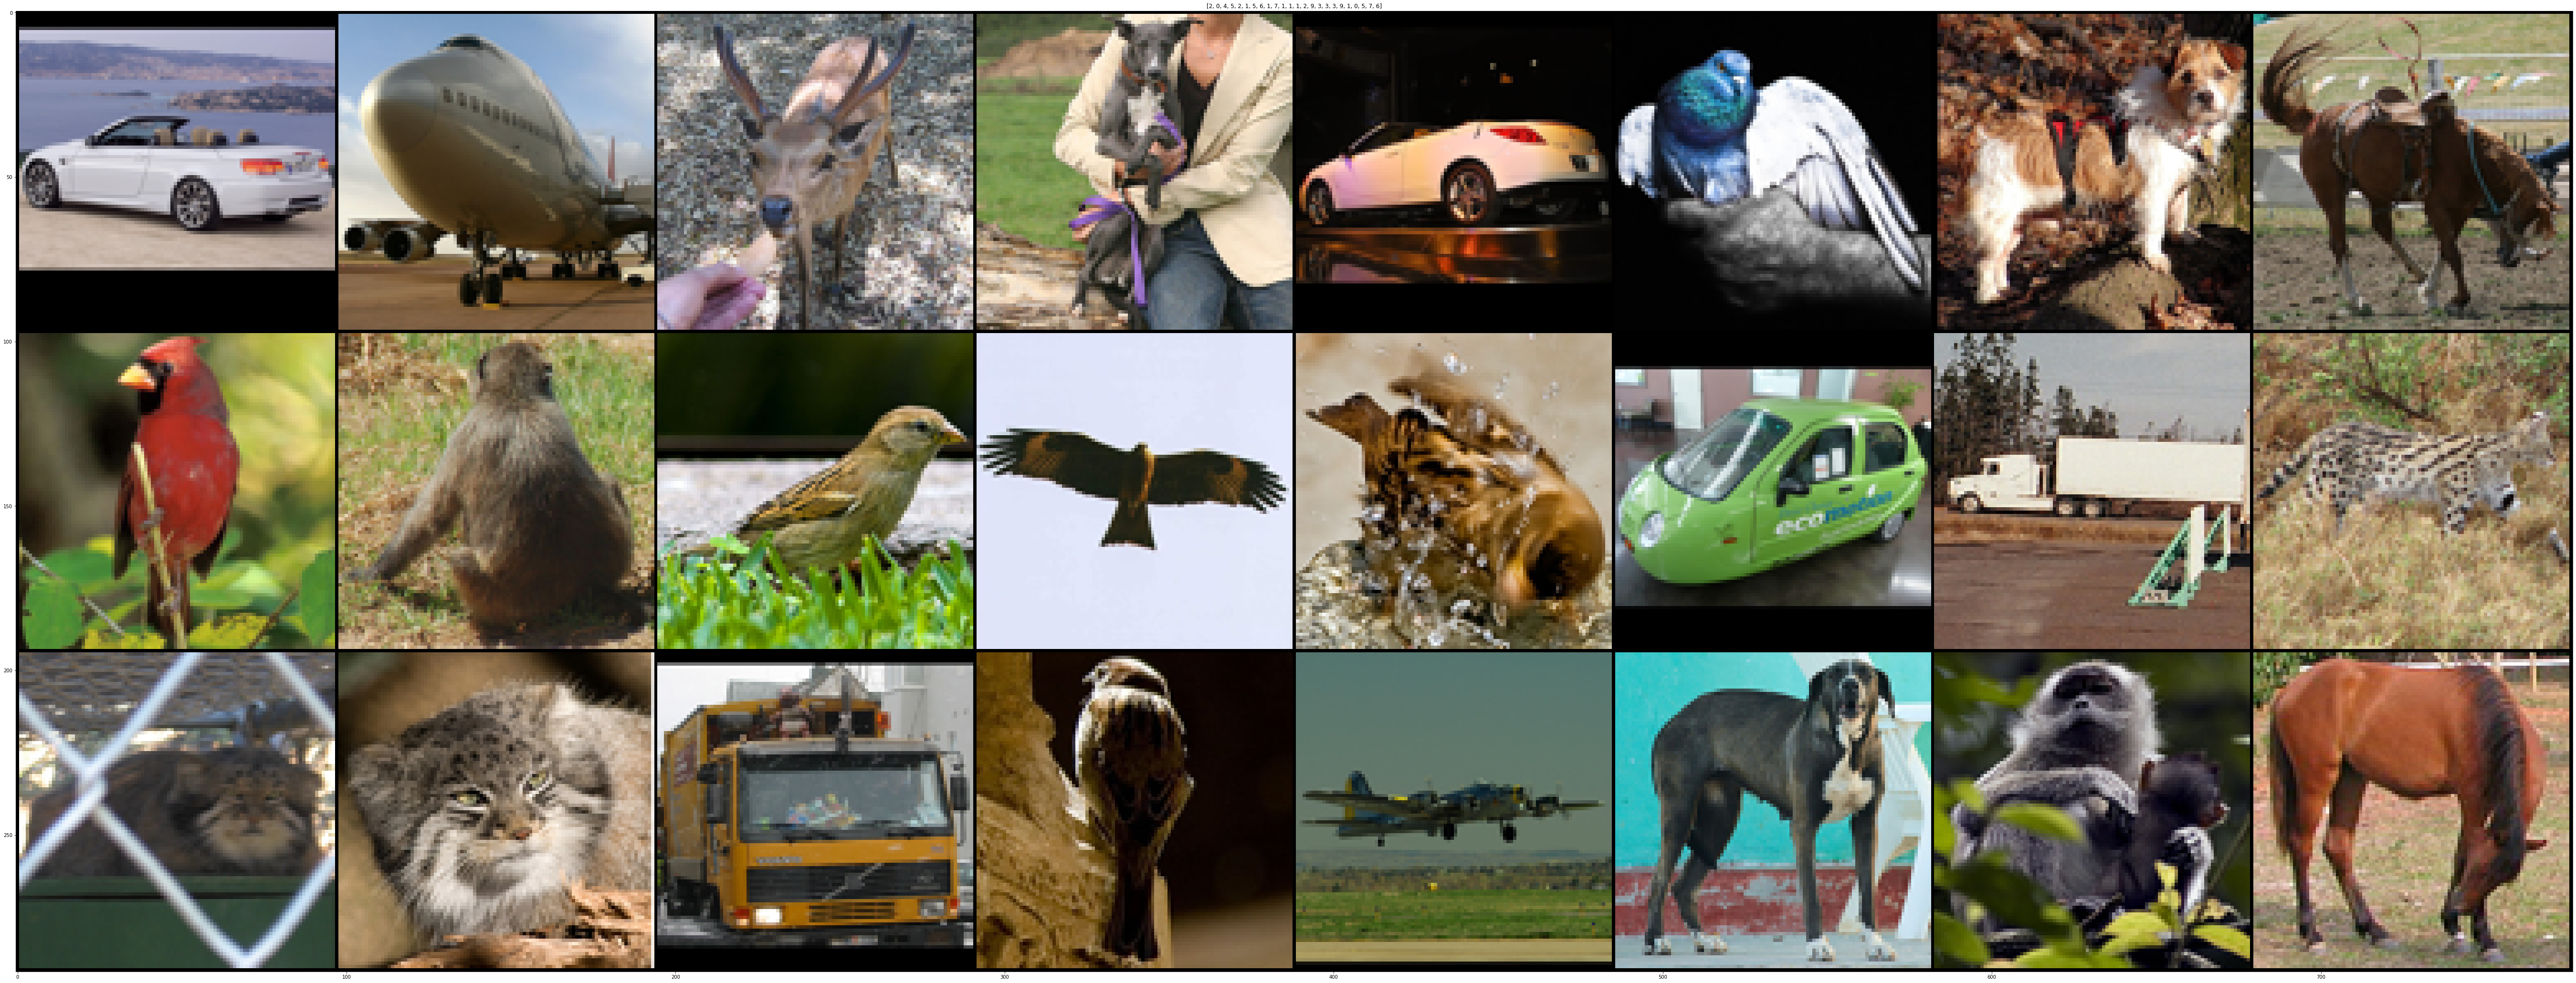

In [ ]:
show_img(train_ds)

In [ ]:
show_img(test_ds)

In [ ]:
meanRGB = [np.mean(x.numpy(), axis=(1, 2)) for x, _ in train_ds]
stdRGB = [np.std(x.numpy(), axis=(1, 2)) for x, _ in train_ds]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.std([s[0] for s in stdRGB])
stdG = np.std([s[1] for s in stdRGB])
stdB = np.std([s[2] for s in stdRGB])

train_transformer = torchvision.transforms.Compose([
                  torchvision.transforms.RandomVerticalFlip(p=0.5),
                  torchvision.transforms.RandomHorizontalFlip(p=0.5),
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize([meanR,meanG,meanB], [stdR,stdG,stdB])
])

test_transformer = torchvision.transforms.Compose([
                   torchvision.transforms.ToTensor(),
                   torchvision.transforms.Normalize([meanR,meanG,meanB], [stdR,stdG,stdB])
])
train_ds.transform = train_transformer
test_ds.transform = test_transformer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 292, 777])


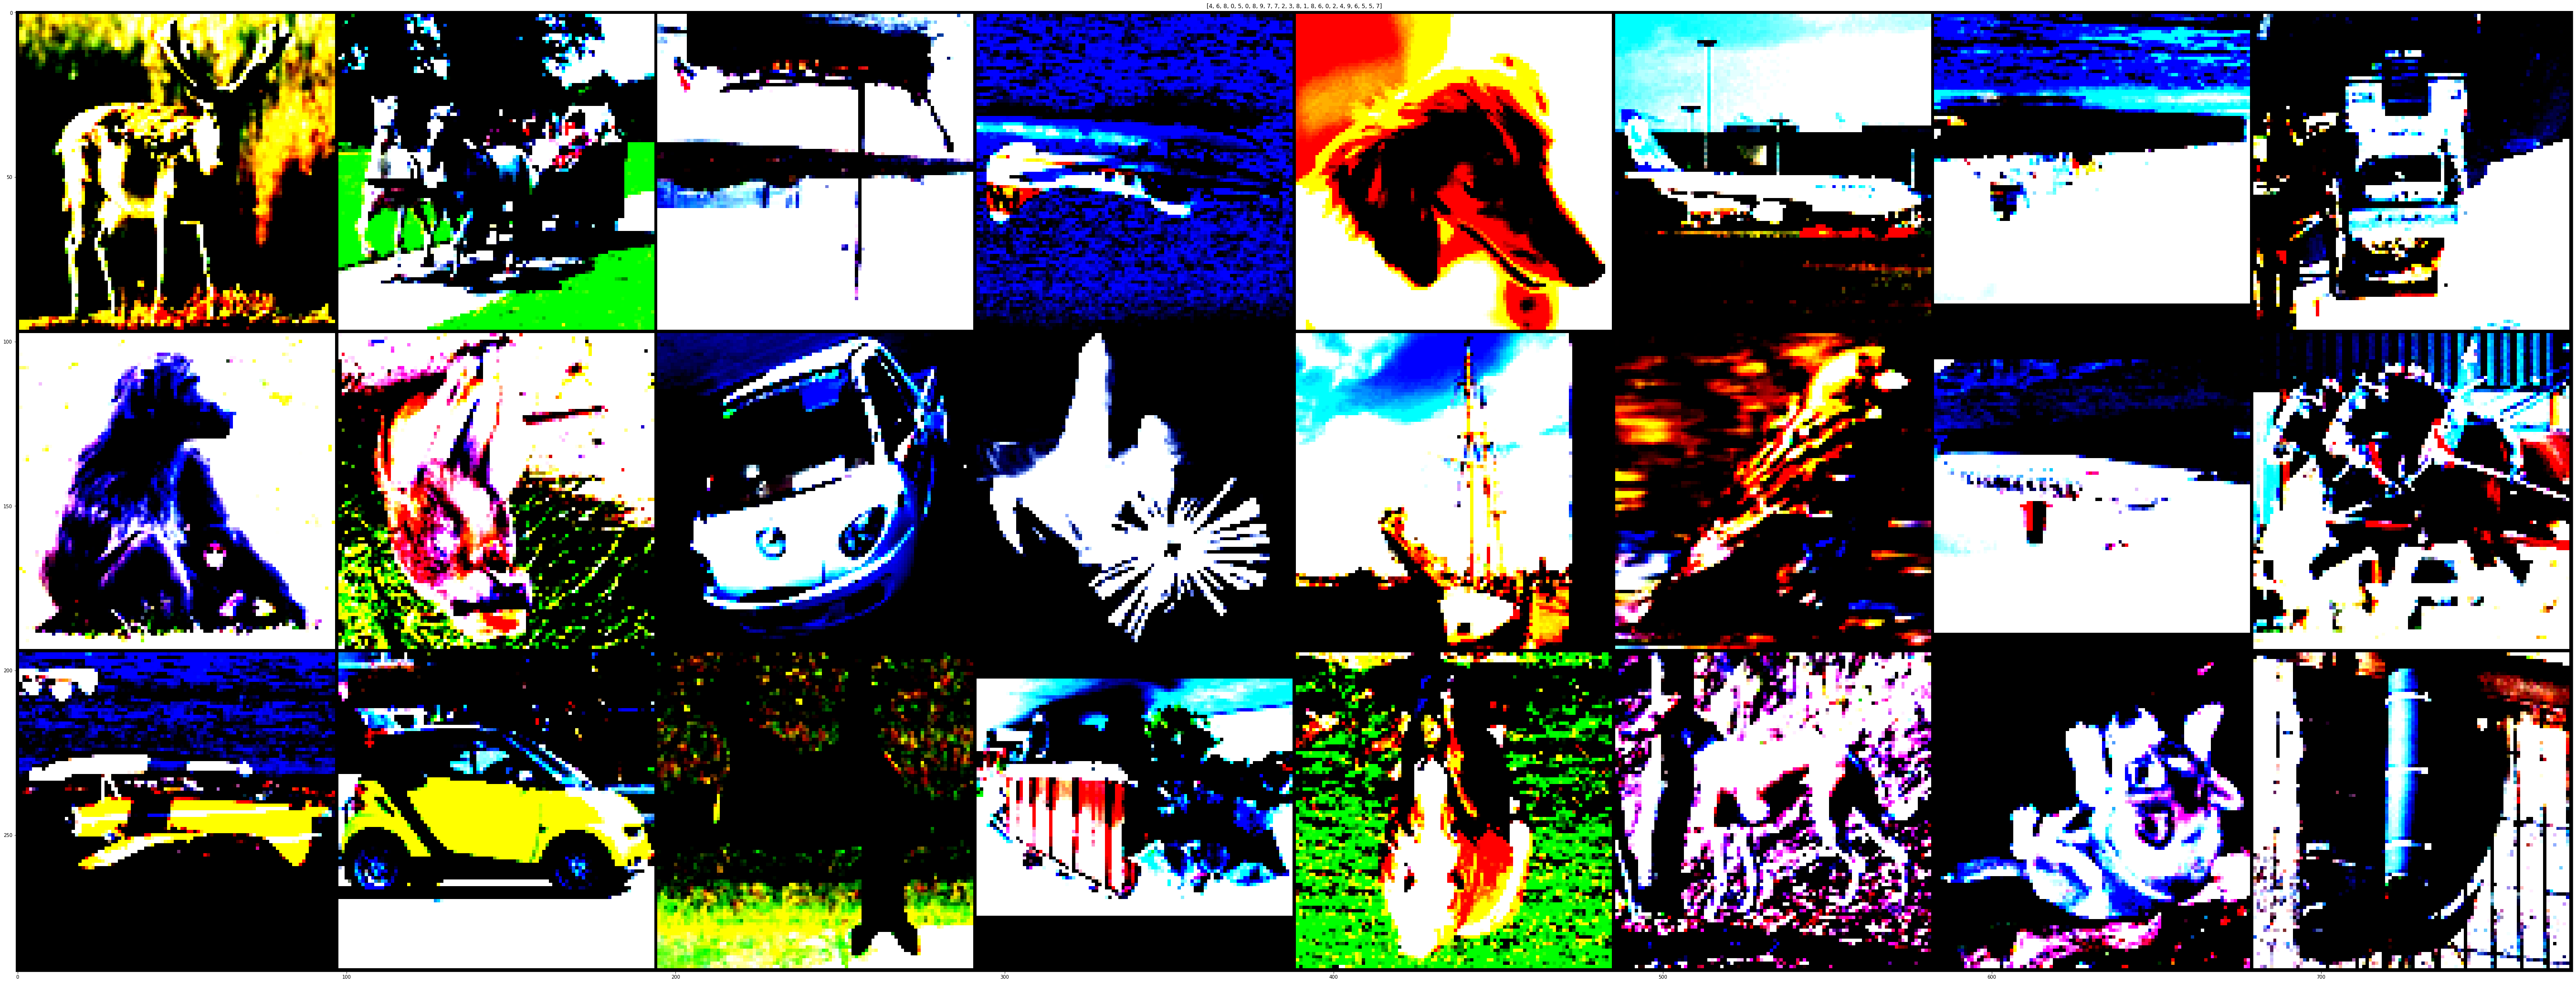

In [ ]:
show_img(train_ds)

In [ ]:
show_img(test_ds)

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds,
                                      batch_size=32,
                                      shuffle=True)

val_dl = torch.utils.data.DataLoader(val,
                                     batch_size=32,
                                     shuffle=False)

#2.Model

In [ ]:
model_resnet18 = torchvision.models.resnet18(pretrained=False)
model_resnet18_pretrained = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
num_classes = 10
num_features = model_resnet18.fc.in_features
model_resnet18.fc = torch.nn.Linear(num_features, num_classes)
model_resnet18 = model_resnet18.to(device)

num_classes = 10
num_features = model_resnet18_pretrained.fc.in_features
model_resnet18_pretrained.fc = torch.nn.Linear(num_features, num_classes)
model_resnet18_pretrained = model_resnet18_pretrained.to(device)

In [ ]:
torchsummary.summary(model_resnet18, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
def show_Conv2d_layer_weights(model, layer_num=1):
  for i, w in enumerate(model.parameters()):
      w = w.data.cpu()
      if i+1 == layer_num:
        break

  #Normalize weights
  w1 = (-1 / (2*torch.min(w))) * w + 0.5
  print(w.shape, torch.min(w1), torch.max(w1))
  show_img(w1, with_y=False, rand=False)

In [ ]:
show_Conv2d_layer_weights(model_resnet18, 1)

In [ ]:
show_Conv2d_layer_weights(model_resnet18_pretrained, 1)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')

"""An important argument in defining the
loss function to pay attention to is reduction, which specifies the reduction to apply to the
output. There are three options to choose from: none, sum, and mean. We choose
reduction="sum" so the output loss will be summed. Since we will process the data in
batches, this will return the sum of loss values per batch of data."""

"""
The resnet18 model defined in the Building the model section has linear outputs with no
activation function. Therefore, we choose nn.CrossEntropyLoss as the loss function. This
loss function combines nn.LogSoftmax() and nn.NLLLoss() in one class.
"""

"""
The learning rate starts from the set value in the optimizer
lr=1e-4. Then, it gradually decreases toward eta_min=1e-5 and returns back to the original
set value in 2*T_max=4 iterations."""
optimizer = torch.optim.Adam(model_resnet18.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2, eta_min=1e-5)


optimizer_pre = torch.optim.Adam(model_resnet18_pretrained.parameters(), lr=1e-4)
lr_scheduler_pre = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_pre, T_max=2, eta_min=1e-5)

In [ ]:
def loss_epoch(model, dataset, loss_fn, sanity_check=True, optimizer=None):
  
  temploss, loss= 0.0, 0.0
  tempaccuracy, accuracy= 0, 0.0
  accuracy_1 = 0.0
  for x, y in dataset:
    x = x.to(device)
    y = y.to(device)

    output = model(x)
    temploss = loss_fn(output, y)

    if optimizer is not None:
      optimizer.zero_grad()
      temploss.backward()
      optimizer.step()

    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(y.view_as(pred)).sum().item()
    # loss += temploss.cpu().detach().numpy()
    loss += temploss.item()
    accuracy += corrects
    if sanity_check:
      break

  loss /= len(dataset.dataset)  
  accuracy /= len(dataset.dataset)  
  return loss, accuracy

In [ ]:
import copy
def get_lr(opt):
  for param_group in opt.param_groups:
    return param_group['lr']

def train_val(model, params):
    num_epochs = params['num_epochs'] 
    loss_fn = params['loss_func'] 
    opt = params['optimizer'] 
    train_dl = params['train_dl'] 
    val_dl = params['val_dl'] 
    sanity_check = params['sanity_check']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']

    loss_history = {'train': [], 'val': []}
    accuracy_history = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
      current_lr = get_lr(optimizer)
      print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))

      model.train()
      train_loss, train_accuracy = loss_epoch(model, train_dl, loss_fn, sanity_check, optimizer)
      loss_history['train'].append(train_loss)
      accuracy_history['train'].append(train_accuracy)


      model.eval()
      with torch.no_grad():
        val_loss, val_accuracy = loss_epoch(model, val_dl, loss_fn, sanity_check)
        loss_history['val'].append(val_loss)
        accuracy_history['val'].append(val_accuracy)

      if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), path2weights)
        print('The best Model has been saved !!!')

      lr_scheduler.step()
      if current_lr != get_lr(opt):
        print('loading best model weights')
        model.load_state_dict(best_model_wts)
      print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: %{train_accuracy*100:.3f}, Val Loss: {val_loss:.4f}, Val Accuracy: %{val_accuracy*100:.3f}")

    model.load_state_dict(best_model_wts)
    return model, loss_history, accuracy_history

In [ ]:
os.makedirs('/content/models', exist_ok=True)

params_train = {
    'num_epochs': 100,
    'optimizer': optimizer,
    'loss_func': loss_fn,
    'train_dl': train_dl,
    'val_dl': val_dl,
    'sanity_check' : False,
    'lr_scheduler': lr_scheduler,
    'path2weights': '/content/models/resnet18.pt'
}

params_train_pre = {
    'num_epochs': 100,
    'optimizer': optimizer_pre,
    'loss_func': loss_fn,
    'train_dl': train_dl,
    'val_dl': val_dl,
    'sanity_check' : False,
    'lr_scheduler': lr_scheduler_pre,
    'path2weights': '/content/models/resnet18_pre.pt'
}

In [ ]:
model, loss_history, accuracy_history = train_val(model_resnet18, params_train)

Epoch 0/99, current lr=0.0001
The best Model has been saved !!!
loading best model weights
Epoch: 0, Train Loss: 1.7656, Train Accuracy: %32.740, Val Loss: 1.5568, Val Accuracy: %40.062
Epoch 1/99, current lr=5.5e-05
The best Model has been saved !!!
loading best model weights
Epoch: 1, Train Loss: 1.3990, Train Accuracy: %48.280, Val Loss: 1.4026, Val Accuracy: %46.312
Epoch 2/99, current lr=1e-05
The best Model has been saved !!!
loading best model weights
Epoch: 2, Train Loss: 1.2201, Train Accuracy: %56.880, Val Loss: 1.3554, Val Accuracy: %48.250
Epoch 3/99, current lr=5.4999999999999995e-05
loading best model weights
Epoch: 3, Train Loss: 1.1847, Train Accuracy: %57.340, Val Loss: 1.4084, Val Accuracy: %47.812
Epoch 4/99, current lr=0.0001
loading best model weights
Epoch: 4, Train Loss: 1.2671, Train Accuracy: %54.260, Val Loss: 1.5577, Val Accuracy: %44.062
Epoch 5/99, current lr=5.500000000000001e-05
loading best model weights
Epoch: 5, Train Loss: 1.1830, Train Accuracy: %57.

In [ ]:
model_pre, loss_history_pre, accuracy_history_pre = train_val(model_resnet18_pretrained, params_train_pre)

Epoch 0/99, current lr=9.999999999999941e-05
The best Model has been saved !!!
loading best model weights
Epoch: 0, Train Loss: 2.6972, Train Accuracy: %8.900, Val Loss: 2.8652, Val Accuracy: %8.750
Epoch 1/99, current lr=9.999999999999941e-05


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


The best Model has been saved !!!
loading best model weights
Epoch: 1, Train Loss: 2.6823, Train Accuracy: %9.380, Val Loss: 2.8390, Val Accuracy: %9.438
Epoch 2/99, current lr=9.999999999999941e-05
The best Model has been saved !!!
loading best model weights
Epoch: 2, Train Loss: 2.6884, Train Accuracy: %8.940, Val Loss: 2.8196, Val Accuracy: %9.812
Epoch 3/99, current lr=9.999999999999941e-05
loading best model weights
Epoch: 3, Train Loss: 2.6728, Train Accuracy: %9.200, Val Loss: 2.8230, Val Accuracy: %9.688
Epoch 4/99, current lr=9.999999999999941e-05
loading best model weights
Epoch: 4, Train Loss: 2.6778, Train Accuracy: %9.120, Val Loss: 2.8207, Val Accuracy: %9.062
Epoch 5/99, current lr=9.999999999999941e-05
loading best model weights
Epoch: 5, Train Loss: 2.6890, Train Accuracy: %9.340, Val Loss: 2.8577, Val Accuracy: %8.938
Epoch 6/99, current lr=9.999999999999941e-05
loading best model weights
Epoch: 6, Train Loss: 2.6888, Train Accuracy: %9.380, Val Loss: 2.8514, Val Accu

100


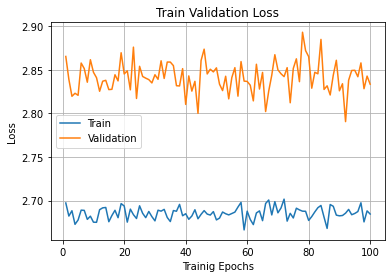

In [ ]:
plot_history(loss_history_pre, loss=True)

100


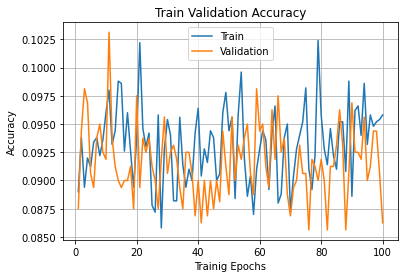

In [ ]:
plot_history(accuracy_history_pre, loss=False)

100


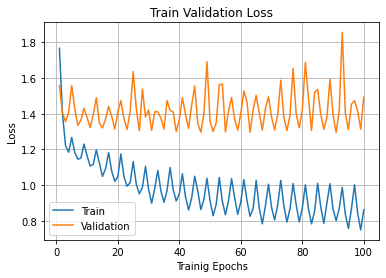

In [ ]:
plot_history(loss_history, loss=True)

100


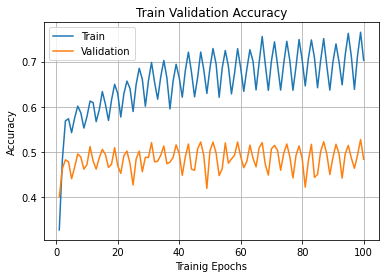

In [ ]:
plot_history(accuracy_history, loss=False)

#3.Deploy

In [ ]:
model = torchvision.models.resnet18(pretrained=False)
num_features = model.fc.in_features
num_classes = 10
model.fc = torch.nn.Linear(num_features, num_classes)
# path2weights ="/content/models/resnet18_pretrained.pt"
path2weights = '/content/models/resnet18.pt'
    
model.load_state_dict(torch.load(path2weights))

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
def deploy_model(model, dataset, device, num_classes=10, sanity_check=False):

  len_data = len(dataset.dataset)
  y_out = torch.zeros(len_data, num_classes)
  y_gt = np.zeros((len_data), dtype='uint8')
  model = model.to(device)
  with torch.no_grad():
    for i in range(len_data):
      x, y = dataset.dataset[i]
      y_gt[i] = y
      yy = model(x.unsqueeze(0).to(device))
      y_out[i] = torch.softmax(yy, dim=1)
      if sanity_check:
        break
  return y_out.numpy().argmax(axis=1), y_gt

In [ ]:
y_out, y_get = deploy_model(model, test, device)

In [ ]:
print(100 * np.sum(y_get == y_out) / len(y_get))

51.9
